# CREDIT CARD FRAUD DETECTION

Autor: Manel Carrillo Maíllo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm 
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


Començaré fent una investigació del dataset per veure quins són els problemes hauré de superar

## Principal Problema:

Desbalaceig molt gran de dades. Com podem resoldre aquest problema?

## Objectiu

Poder balancejar les dades amb tècniques d'oversampling i undersampling

Ser capaç de poder detetctar amb precisió fraus tot i el desbalanceig 

Plantejar el problema com un problema d'outluier detection amb autoencoders

## EDA

Exploració del dataset

In [2]:
df = pd.read_csv("creditcard.csv")
print("files i columnes:", df.shape) # com es el nostre dataset
df.head()

files i columnes: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Aquest dataset consta d'un total de 31 columnes:

    Time-> Temps que hi ha entre la primera transacció i aquesta

    Amount-> Quantitat de la transacció

    Class-> 0: Not fraud , 1: Fraud

    Vi (i [1,29]) -> Components principals que s'han obtingut al fer un PCA. No tenim és informació sobre aquestes ja que s'han protegit les dades.

Mirem com són els nostres atributs

In [4]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

No tenim variables categòriques.

No haurem de fer cap tipus d'encoding per a les variables catergòriques.

Per poder tenir més informació del nostre dataset i dels nostres atributs fem un describe (màxim, mínim , mitja, std...).  

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### PROBLEMA PRINCIPAL
Podem veure que la mitjana de l'atribut de la variable class és de 0.001727 (valor molt proper a 0), fet que indica un GRAN desbalanceig.


Mirem si tenim nans.

In [6]:
total_nans = df.isna().sum().sum()
print("En aquest dataset hi ha un total de", total_nans, "nans")
prc_nans= (total_nans/df.size)*100
print(f"El percentatge de nans en el nostre DataFrame és: ",prc_nans)

En aquest dataset hi ha un total de 0 nans
El percentatge de nans en el nostre DataFrame és:  0.0


No haurem de fer cap tipus de encoding per a l'emplenat de nans.

#### Plots d'informació

1. Plot de quantitat de valors per classes

Amb aquest plot es pot saber si tenim dades balancejades o no

Transaccion fraudulentes: 492
Transaccions no Fraudulentes 284315


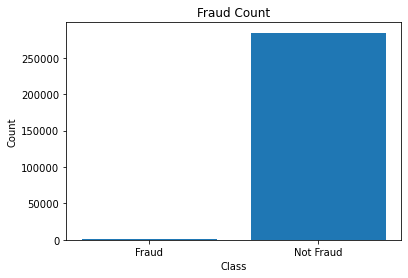

Percentage de Fraud: 0.17%
Percentage de Not Fraud: 99.83%


In [7]:
fraud_num = df['Class'].sum()
nofraud_num = df['Class'].size - fraud_num
print("Transaccion fraudulentes:",fraud_num )
print("Transaccions no Fraudulentes", nofraud_num)
fraud_percentage = (fraud_num / df['Class'].size) * 100
nofraud_percentage = (nofraud_num / df['Class'].size) * 100

x = ['Fraud', 'Not Fraud']
y = [fraud_num, nofraud_num]

plt.bar(x, y)
plt.title('Fraud Count')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print('Percentage de Fraud: {:.2f}%'.format(fraud_percentage))
print('Percentage de Not Fraud: {:.2f}%'.format(nofraud_percentage))


Tal com hem deduit anteriorment, tenim dades molt desbalancejades, pràcticament és com si no tinguessim cassos de Frauds. 

Aquest és el principal problema a tractar en aquest projecte i que resoldrem de varies maneres per finalment indicar quina ha estat la millor

#### Plots de variables contra class

In [8]:
# for col in df.columns.drop('Class'):
#     g = sns.FacetGrid(df, col='Class')
#     g.map(plt.hist, col, bins=20)
#     plt.subplots_adjust(top=0.8)
#     g.fig.suptitle(f'{col} vs Class')
#     plt.show()

Podem mirar si es fan transaccions fraudulentes en algun temps específic per trobar patrons fent un histograma de les transaccions fraudolentes en el temps

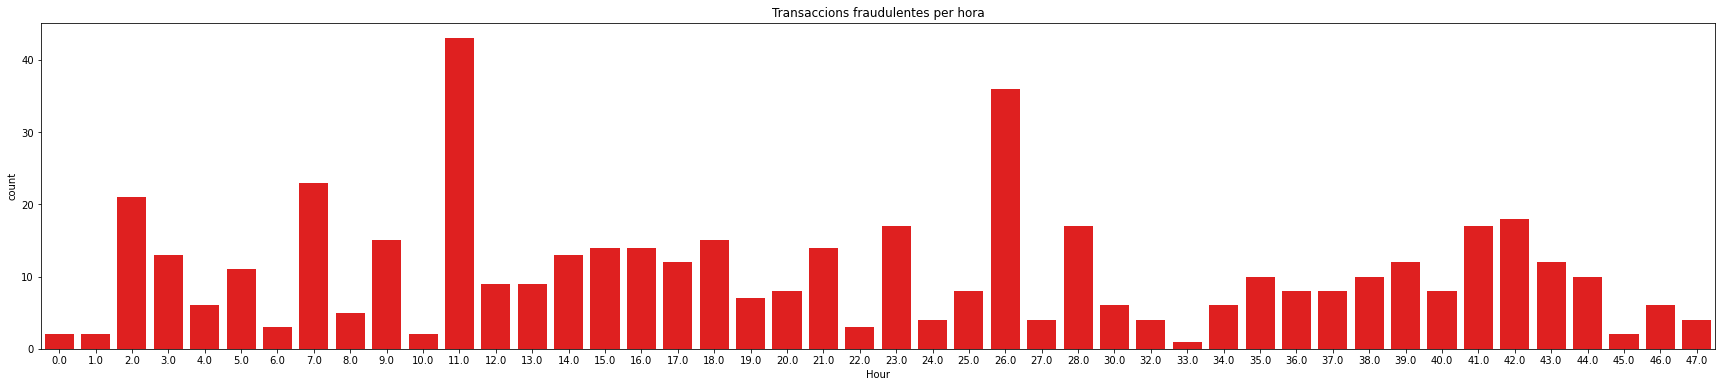

In [9]:
df['Hour'] = df['Time'] // 3600
plt.figure(figsize=(30, 6))
sns.countplot(x='Hour', data=df[df['Class'] == 1], color='red') 
plt.title('Transaccions fraudulentes per hora')
plt.show()
df = df.drop('Hour', axis=1)


No tenim cap tipus de patró clar on es facin més transaccions fraudulentes

### Detectem i treiem outliers del nostre Dataset amb mètode IQR

He fet diferents execucions eliminant outliers de diferents maneres i sense eliminar outliers.

El mètode IQR dona resultats més bons a l'hora de generalitzar el model al final. Interessa no tenir outliers per no generar més a les tècniques d'oversampling o undersampling.

In [10]:
rej_class = ['Class']
features = [i for i in df.columns if i not in rej_class]
for feature in features:
    val = df[feature].loc[df['Class'] == 1].values
    q25, q75 = np.percentile(val, 25), np.percentile(val, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in val if x < lower or x > upper]
    df = df.drop(df[(df[feature] > upper) | (df[feature] < lower)].index)
df.shape
fraud_num = df['Class'].sum()
nofraud_num = df['Class'].size - fraud_num
print("Transaccion fraudulentes:",fraud_num )
print("Transaccions no Fraudulentes", nofraud_num)

Transaccion fraudulentes: 181
Transaccions no Fraudulentes 196441


## Separació Train Test

En aquest apartat d'aquí separarem les dades de train i test, aplicarem la normalització amb un standardscaler i farem una representació visual de les dades amb un PCA reduint a 2 dimensions.

En aquesta part, es solucionarà el problema de desbalanceig de dades aplicant dades d'oversampling i d'undersampling generant el pca de cada mètode i comparant de manera general la matriu de confusió d'aquests mètodes fent també una representació de les dades amb un PCA per veure com aquestes tècniques han actuat a l'hora d'equilibrar les dades.

### Normalització de dades

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Class', axis=1), 
    df['Class'],  
    test_size=0.2, 
    stratify=df['Class'], 
    random_state=33
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

### PCA

Representem les nostres dades en 2 dimensions mitjançant un PCA

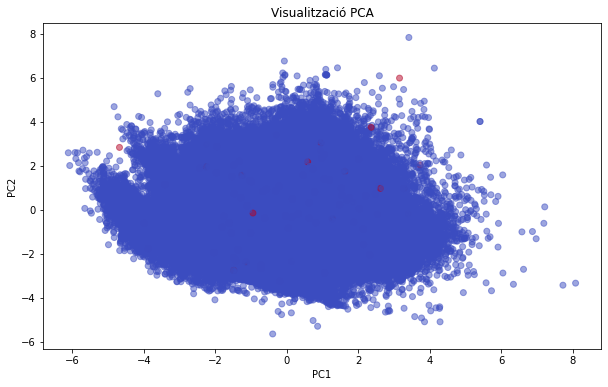

In [12]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

df_train_pca = pd.DataFrame(data=X_train_pca, columns=['PC1', 'PC2'])
df_train_pca['Class'] = y_train

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_train_pca['PC1'], df_train_pca['PC2'], c=df_train_pca['Class'], cmap='coolwarm', alpha=0.5)

plt.title('Visualització PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


OBSERVACIONS DEL PCA
-> És molt difícil trobar dades de la classe 1 degut al desbalanceig

<AxesSubplot:>

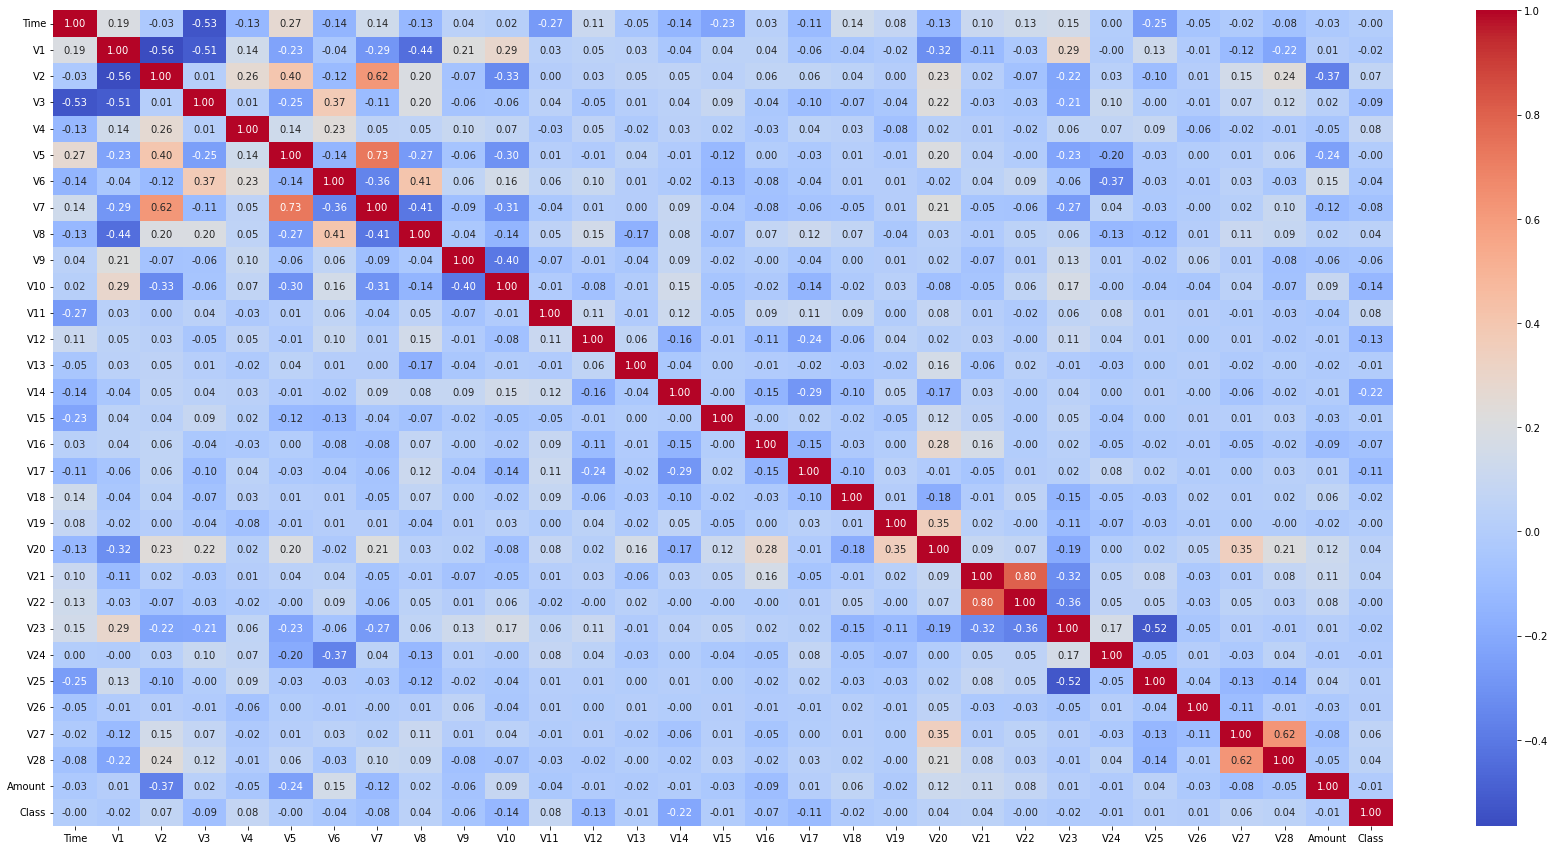

In [13]:
corr = df.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(corr,cmap='coolwarm', annot=True, fmt=".2f")

Si fem un anàlisis general de la matriu de correlacions del nostre dataset debalancejat, podem veure que no hi ha cap variable correlacionada amb la variable target.
Canviarà aquest anàlisis a l'aplicar tècniques d'obersampling o undersampling? Seguim veient.

## ATACANT EL PROBLEMA DE DESBALANCEIG! 
## TÈCNIQUES D'OVERSAMPLING I UNDERSAMPLING

Com bé s'ha mencionat amb anteroiritat, el principal problema que tenim és el desbalanceig de dades a la variable target "class" i es solucionarà a partir de tècniques d'oversampling i undersampling.

Tècniques D'undersampling:
1. Random undersampling: escollir aleatòriament algunes classes per eliminar-les del conjunt de dades.
2. NearMiss Undersampling: buscar els punts propers a l'extrem de la distància i eliminar els punts que estan més allunyats.
3. CNN
4. ENN
5. Tomek Links

Tècniques d'oversampling:
1. Random Over Sampling: Duplicació de mostres de la classe majoritària de manera random
2. SMOTE (Synthetic Minority Over-sampling Technique) : Creació d'instàncies sintètiques a partir de interpolació de punts de  les dades minoritàries

## TÈCNIQUES D'OVERSAMPLING:

### 1. SMOTE

In [14]:
X = df.drop('Class', axis=1)
y = df['Class']
smote = SMOTE(random_state=33)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
y_smote = pd.Series(y_smote, name='Class')
print(y_smote.value_counts())


0    157152
1    157152
Name: Class, dtype: int64


Com podem veure, ara tenim el mateix nombre de dades a la classe 0 i a la classe 1.

Per curiositat, podem veure com s'ha generat les dades de la classe 1 amb l'SMOTE a partir del PCA.

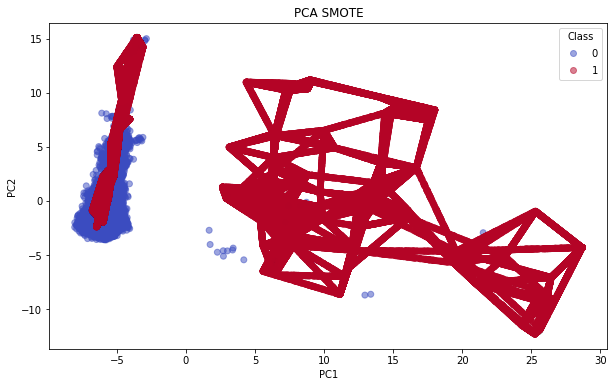

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_smote)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Class'] = y_smote

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Class'], cmap='coolwarm', alpha=0.5)

plt.legend(*scatter.legend_elements(), title='Class')
plt.title('PCA SMOTE')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()


Generem i comparem la matriu de confusió per aquest nou dataset balancejat.

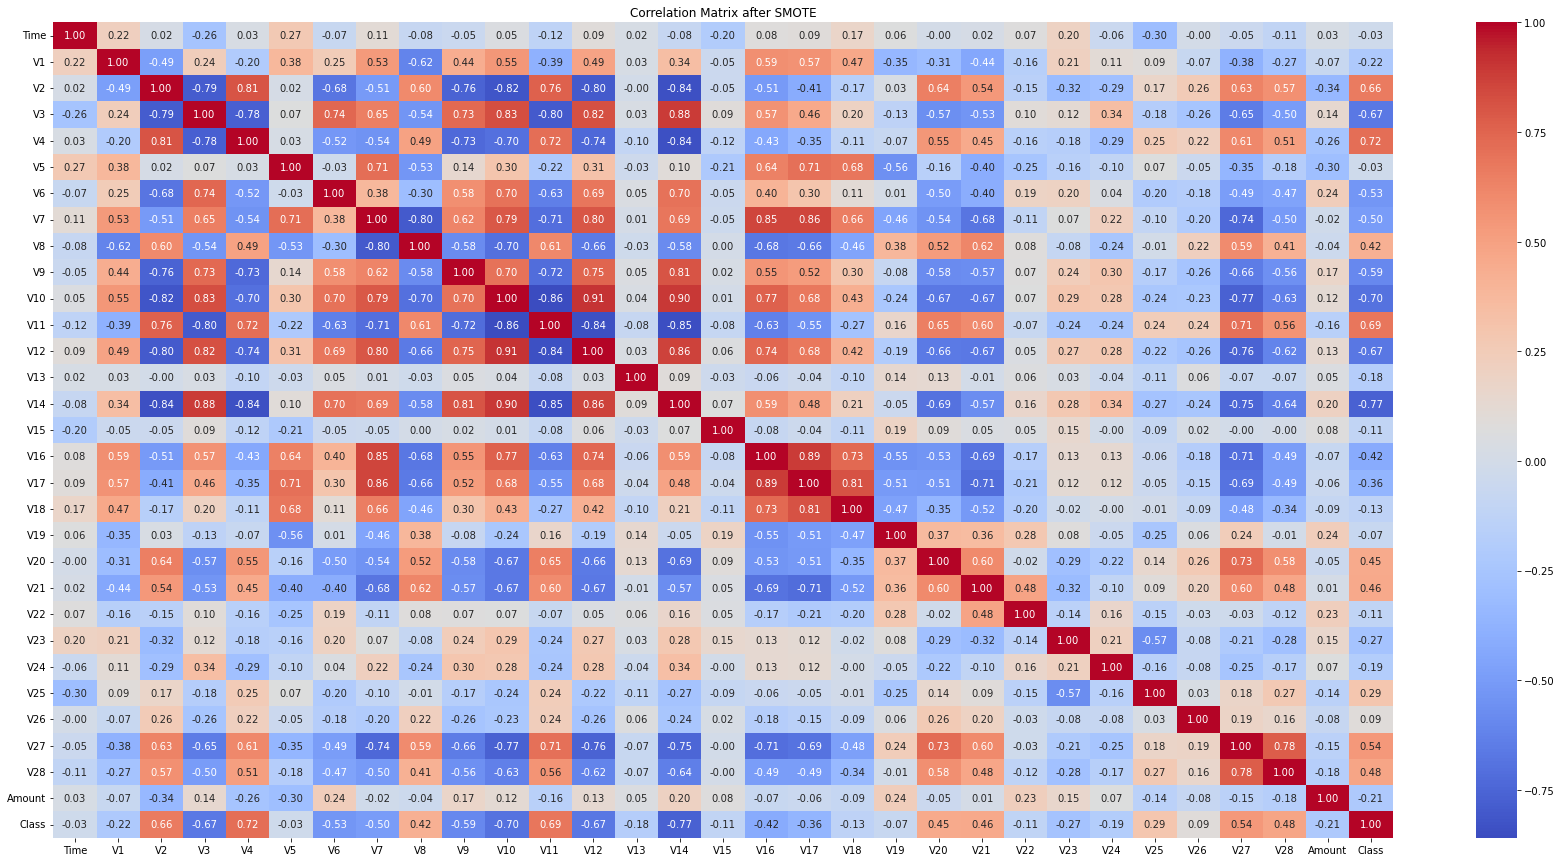

In [16]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=X.columns), pd.DataFrame(y_smote, columns=['Class'])], axis=1)
correlation_matrix_smote = df_smote.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix_smote, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix after SMOTE')
plt.show()


La matriu de confusió és molt diferent a l'anterior generada del dataset desbalancejat. Com podem veure, han aparegut moltes correlacions entre les variables.

Si ens fixem en l'atribut que ens interessa, podem veure que la V2,V4,V11 són les més correlacionades amb la variable class

## 2. Random Over Sampling

In [17]:
ros = RandomOverSampler(random_state=33)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
y_ros = pd.Series(y_smote, name='Class')
print(y_ros.value_counts())

0    157152
1    157152
Name: Class, dtype: int64


Mateix nombre de dades per cada classe.

Mirem com és el PCA en aquest cas

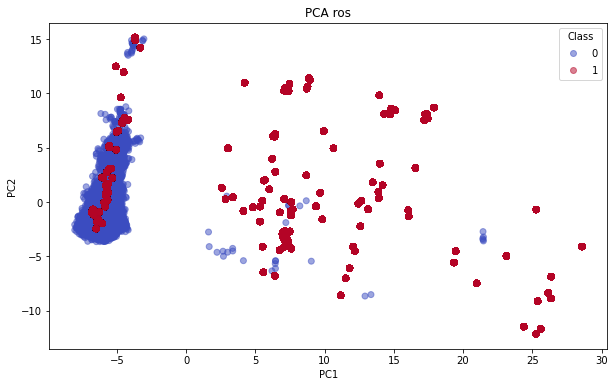

In [18]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_ros)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Class'] = y_ros

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Class'], cmap='coolwarm', alpha=0.5)

plt.legend(*scatter.legend_elements(), title='Class')
plt.title('PCA ros')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

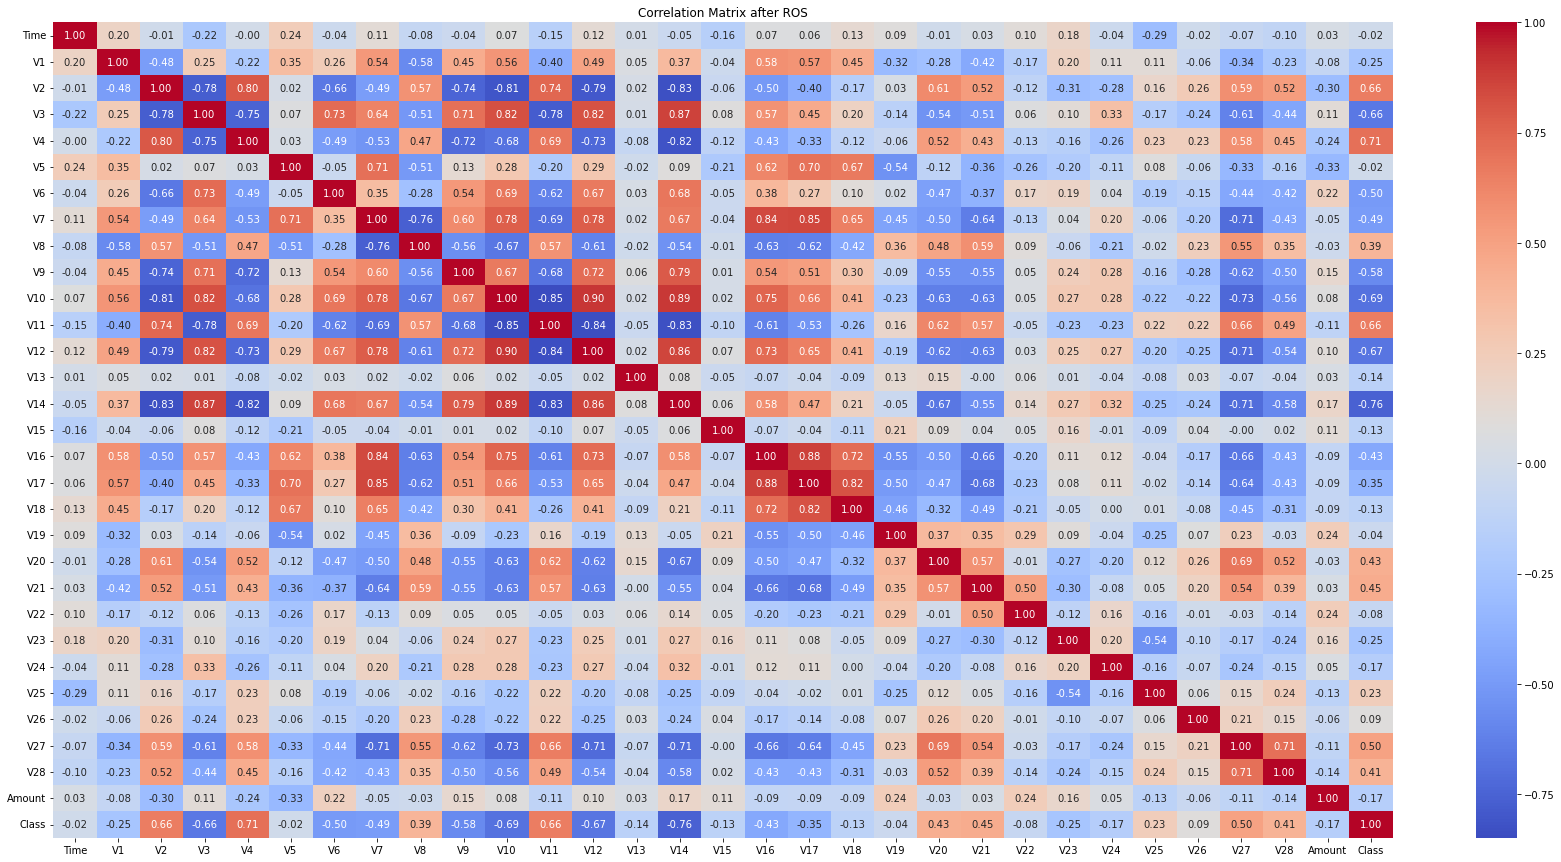

In [19]:
df_ros = pd.concat([pd.DataFrame(X_ros, columns=X.columns), pd.DataFrame(y_ros, columns=['Class'])], axis=1)
correlation_matrix_ros = df_ros.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix_ros, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix after ROS')
plt.show()

Com podem veure, han aparegut correlacions amb la variable classe sobretot amb la variabe v4. En comparació amb la correlació generada per la tecnica SMOTE, aquestes correlacion són més débils.

## TÈCNIQUES D'UNDERSAMPLING


### 1. Random Undersampling

In [20]:
rus = RandomUnderSampler(random_state=33)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print("Class distribution after undersampling:")
print(pd.Series(y_rus).value_counts())


Class distribution after undersampling:
0    145
1    145
Name: Class, dtype: int64


Text(0, 0.5, 'PC2')

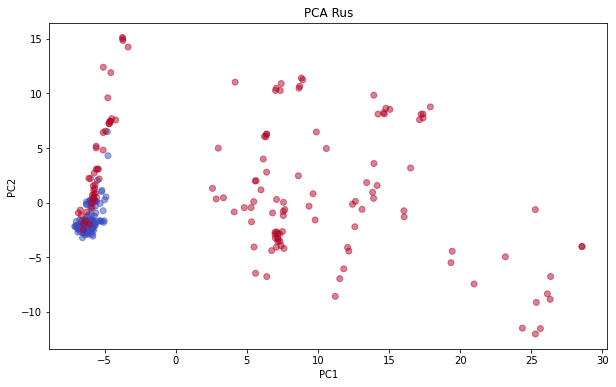

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_rus)
df_train_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_train_pca['Class'] = y_rus
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_train_pca['PC1'], df_train_pca['PC2'], c=df_train_pca['Class'], cmap='coolwarm', alpha=0.5)
plt.title('PCA Rus')
plt.xlabel('PC1')
plt.ylabel('PC2')

La classe 0 ha reduit les seves mostres a  145 .

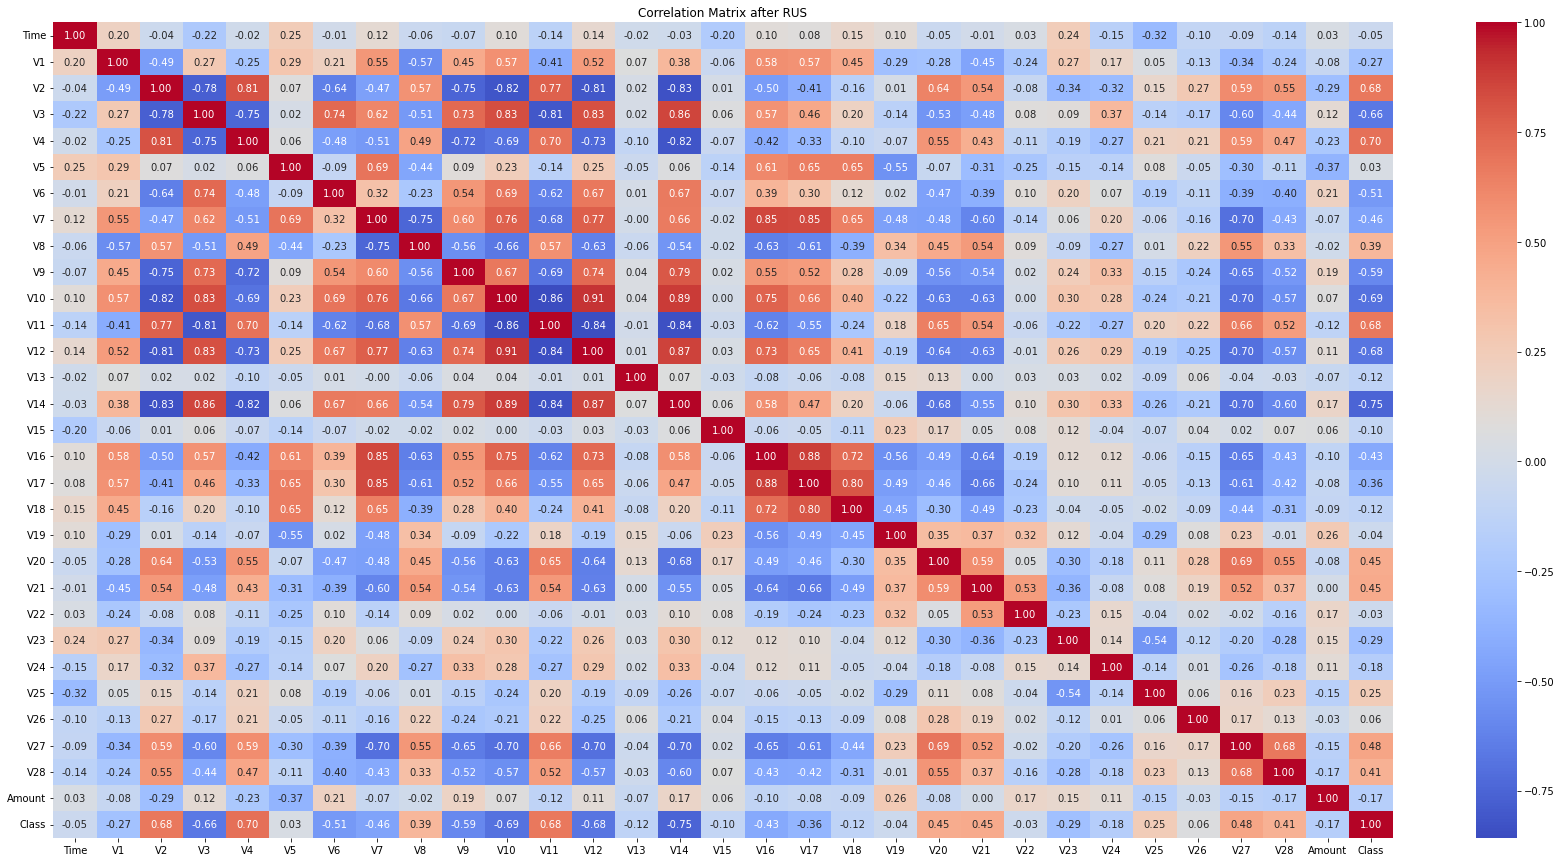

In [22]:
df_rus = pd.concat([pd.DataFrame(X_rus, columns=X.columns), pd.DataFrame(y_rus, columns=['Class'])], axis=1)
correlation_matrix_rus = df_rus.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix_rus, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix after RUS')
plt.show()

Apareixen correlacions amb la variable class destacant la variable V2 i V4

#### Mètode 2: Near Miss

In [23]:
nm = NearMiss()
X_nm, y_nm = nm.fit_resample(X_train, y_train)
print("Near miss:")
print(pd.Series(y_nm).value_counts())

Near miss:
0    145
1    145
Name: Class, dtype: int64


La classe 0 ha reduit les seves mostres a  145 

Text(0, 0.5, 'PC2')

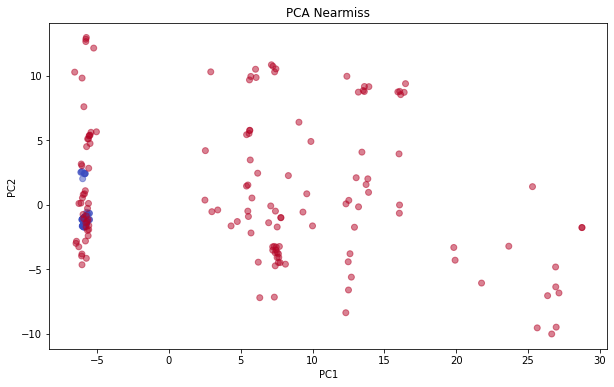

In [24]:
X_pca = pca.fit_transform(X_nm)
pca = PCA(n_components=2)
df_train_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_train_pca['Class'] = y_nm
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_train_pca['PC1'], df_train_pca['PC2'], c=df_train_pca['Class'], cmap='coolwarm', alpha=0.5)
plt.title('PCA Nearmiss')
plt.xlabel('PC1')
plt.ylabel('PC2')

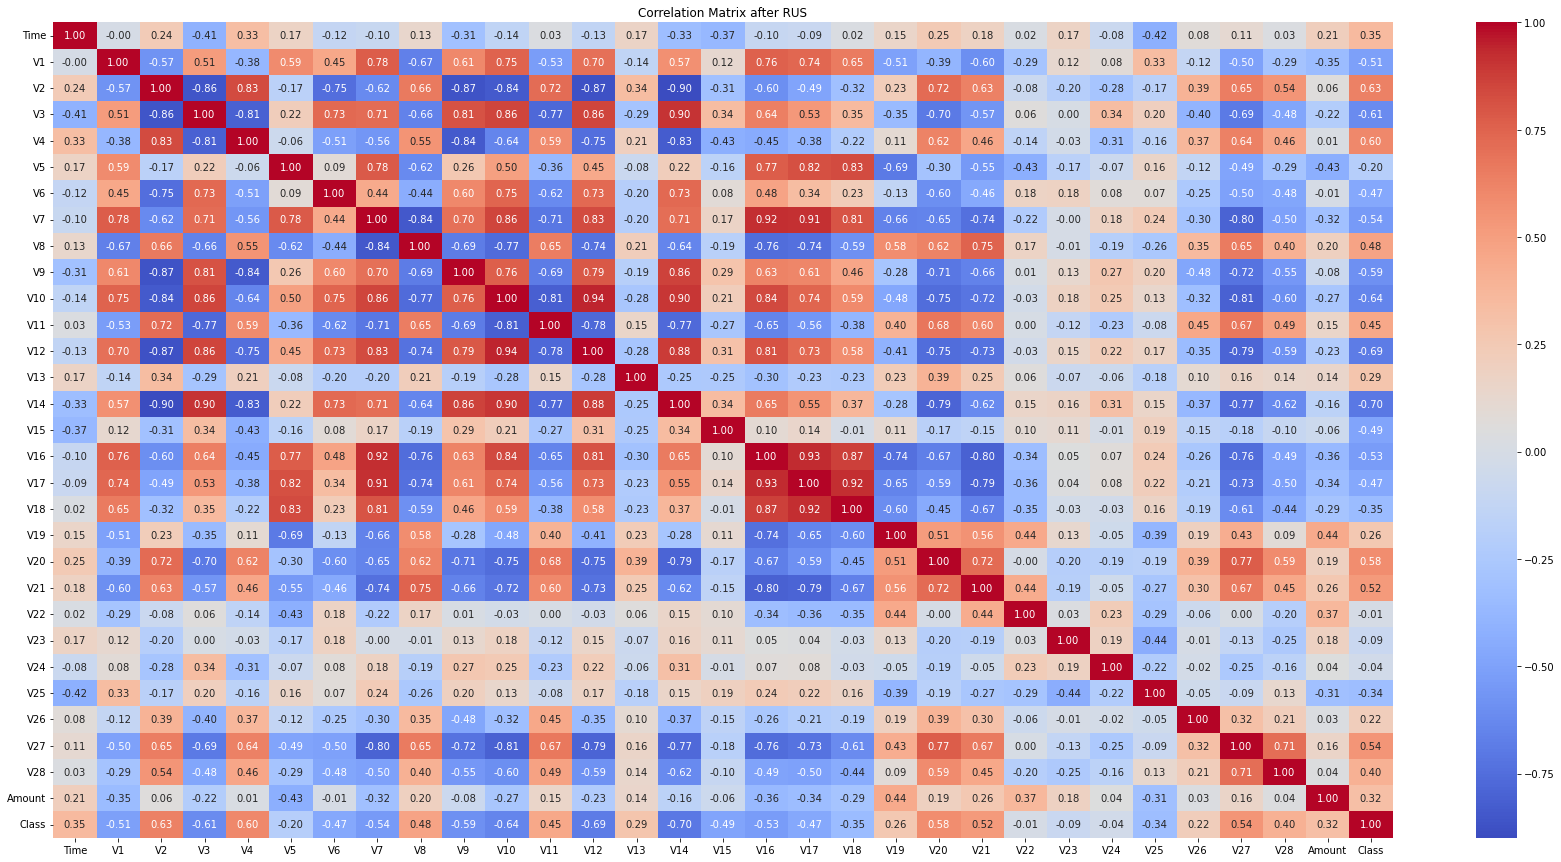

In [25]:
df_nm = pd.concat([pd.DataFrame(X_nm, columns=X.columns), pd.DataFrame(y_rus, columns=['Class'])], axis=1)
correlation_matrix_nm = df_nm.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix_nm, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix after RUS')
plt.show()

Apareixen correlacions amb la variable class destacant la variable V2 i V4

## METRIC SELECTION

En un conjunt de dades desbalancejat, l'accuracy no és una mètrica adequada per avaluar el rendiment del model. Això és degut al fet que, en aquest context, un model que simplement prediu la classe majoritària pot mostrar una precisió aparentment alta, ja que la majoria de les prediccions són correctes per a aquesta classe majoritària. No obstant això, aquest alt valor d'accuracy no reflecteix  la capacitat del model per identificar correctament les instàncies de la classe minoritària.

Creem funcions que ens serviran per a analitzar les mètriques dels nostres models. En aquest cas, farem servir una logistic regression per a probar els diferents datasets que hem creat amb les técniques d'oversampling i undersampling

Mirarem: 
        
        1. Accuracy

        2. Confusion Matrix

        3. Precision

        4. Recall

        5. F1-score

        6. Corva ROC

        7. Corva PR

        8. Threshold

In [26]:
def calculate_accuracy_score(y, y_pred):
    acc_score = accuracy_score(y, y_pred)
    print("Accuracy")
    print(round(acc_score, 2))

def metrics(y,y_pred):
    print("Train confusion Matrix")
    conf = confusion_matrix(y,y_pred)
    sns.set(font_scale=1.4) 
    sns.heatmap(conf, annot=True, annot_kws={"size": 16}, cmap='RdBu', fmt='g')
    plt.show()
    prec,rec,f1, sup = precision_recall_fscore_support(y,y_pred)
    print()
    print('Train')
    print('Precision: ', [round(p, 2) for p in prec])
    print('Recall: ', [round(r, 2) for r in rec])
    print('F1: ', [round(f, 2) for f in f1])
    print('Support: ', sup)

def plot_roc_pr_curves(X, y, model):
    probs = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds_roc = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds_pr = precision_recall_curve(y, probs)
    auc_pr = auc(recall, precision)
    f1_scores = 2 * precision * recall / (precision + recall)
    best_threshold = thresholds_pr[np.argmax(f1_scores)]
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR AUC = {auc_pr:.2f}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    plt.legend()
    print(f"AUC ROC: {roc_auc:.2f}")
    print(f"AUC PR: {auc_pr:.2f}")
    print(f"Optimal Threshold (F1): {best_threshold:.2f}")


Comencem mirant el dataset original on s'espera un accuracy de 1

## Estudi 1:  Dataset Original

Accuracy
1.0
Train confusion Matrix


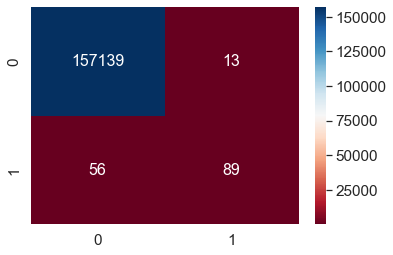


Train
Precision:  [1.0, 0.87]
Recall:  [1.0, 0.61]
F1:  [1.0, 0.72]
Support:  [157152    145]


In [140]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
accuracy_train = calculate_accuracy_score(y_train, y_pred_train)
metrics(y_train, y_pred_train)

Com podem veure, amb el desbalanceig de dades tenim un accuracy de 1 ja que prediu bé la classe majoritària.

També podem veure comparant la recall de les dues classes com hi ha una gran desproporció.


AUC ROC: 0.98
AUC PR: 0.73
Optimal Threshold (F1): 0.49


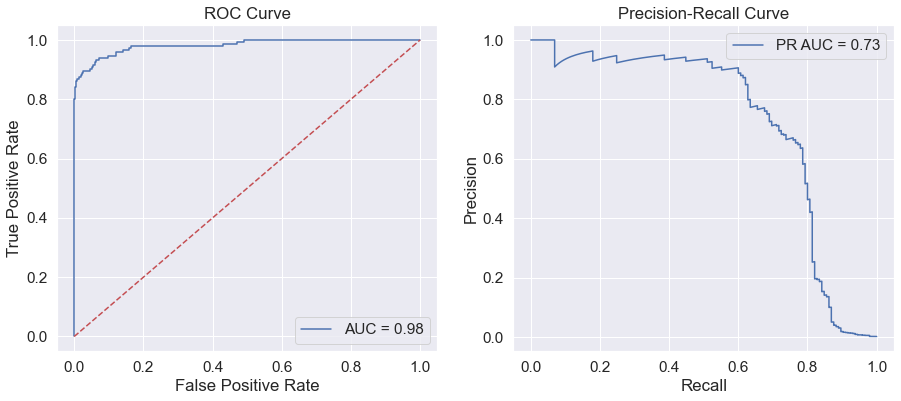

In [141]:
plot_roc_pr_curves(X_train, y_train, lr)

## Estudi 2:  Dataset SMOTE

Accuracy
0.96
Train confusion Matrix


c:\Users\manel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


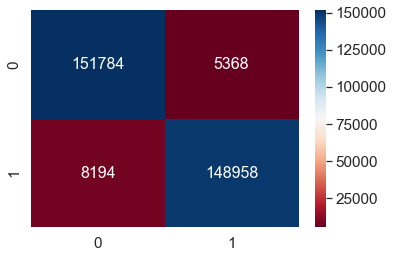


Train
Precision:  [0.95, 0.97]
Recall:  [0.97, 0.95]
F1:  [0.96, 0.96]
Support:  [157152 157152]


In [142]:
lr = LogisticRegression()
lr.fit(X_smote, y_smote)
y_pred_train = lr.predict(X_smote)
accuracy_train = calculate_accuracy_score(y_smote, y_pred_train)
metrics(y_smote, y_pred_train)

AUC ROC: 0.99
AUC PR: 0.99
Optimal Threshold (F1): 0.33


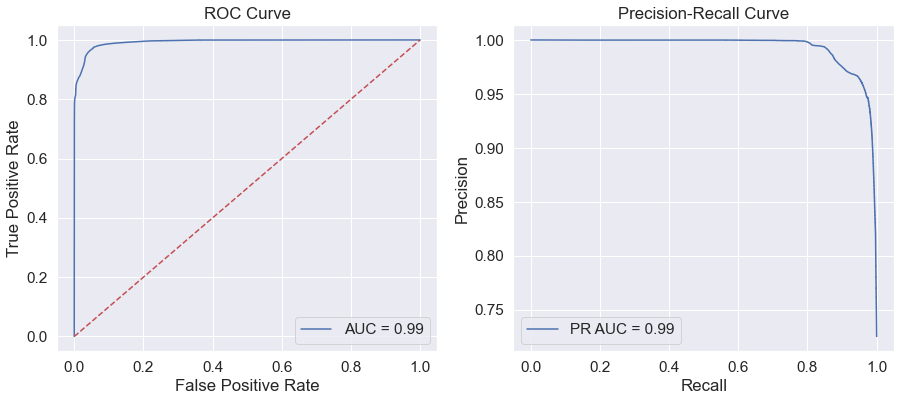

In [143]:
plot_roc_pr_curves(X_smote, y_smote, lr)

## Estudi 3 Random Over Sampling

Accuracy
0.94
Train confusion Matrix


c:\Users\manel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


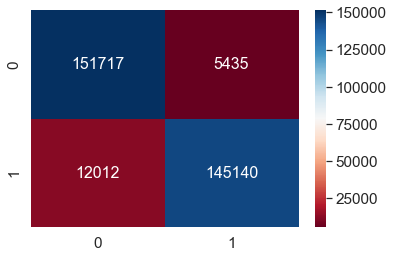


Train
Precision:  [0.93, 0.96]
Recall:  [0.97, 0.92]
F1:  [0.95, 0.94]
Support:  [157152 157152]
AUC ROC: 0.99
AUC PR: 0.99
Optimal Threshold (F1): 0.38


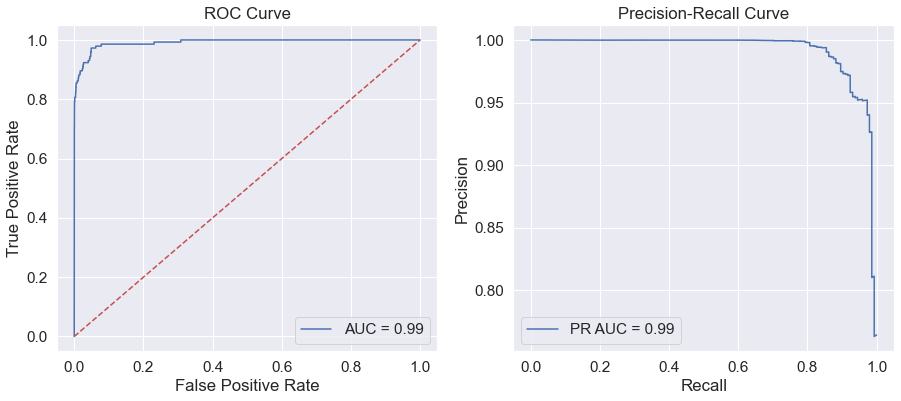

In [144]:
lr = LogisticRegression()
lr.fit(X_ros, y_ros)
y_pred_train = lr.predict(X_ros)
accuracy_train = calculate_accuracy_score(y_ros, y_pred_train)
metrics(y_ros, y_pred_train)
plot_roc_pr_curves(X_ros, y_ros, lr)

## Estudi 4 Random Undersampling

Accuracy
0.96
Train confusion Matrix


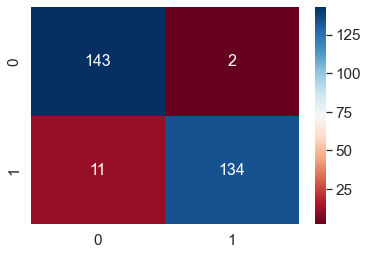


Train
Precision:  [0.93, 0.99]
Recall:  [0.99, 0.92]
F1:  [0.96, 0.95]
Support:  [145 145]


In [145]:
lr = LogisticRegression()
lr.fit(X_rus, y_rus)
y_pred_train = lr.predict(X_rus)

accuracy_train = calculate_accuracy_score(y_rus, y_pred_train)
metrics(y_rus, y_pred_train)


AUC ROC: 0.99
AUC PR: 0.99
Optimal Threshold (F1): 0.39


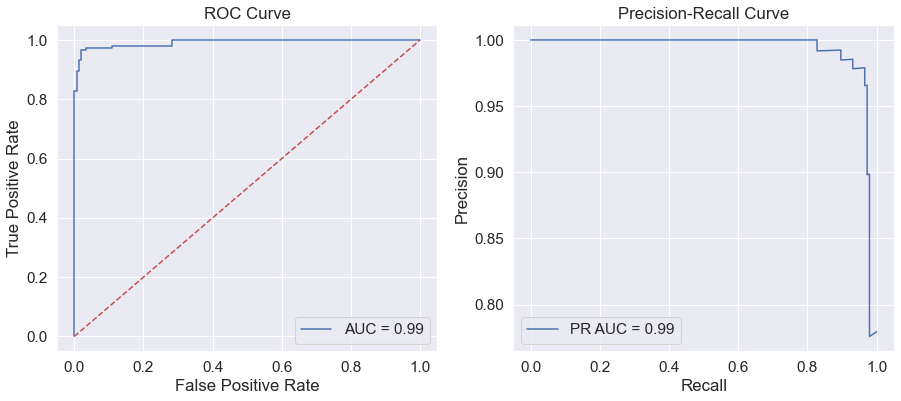

In [146]:
plot_roc_pr_curves(X_rus, y_rus, lr)

## Estudi 5 Near Miss

Accuracy
0.95
Train confusion Matrix


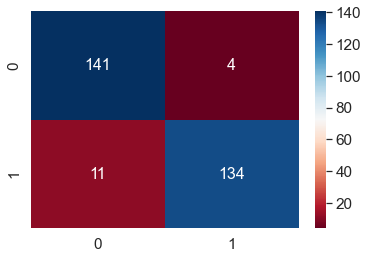


Train
Precision:  [0.93, 0.97]
Recall:  [0.97, 0.92]
F1:  [0.95, 0.95]
Support:  [145 145]


In [147]:
lr = LogisticRegression()
lr.fit(X_nm, y_nm)
y_pred_train = lr.predict(X_nm)
accuracy_train = calculate_accuracy_score(y_nm, y_pred_train)
metrics(y_nm, y_pred_train)


AUC ROC: 0.98
AUC PR: 0.99
Optimal Threshold (F1): 0.57


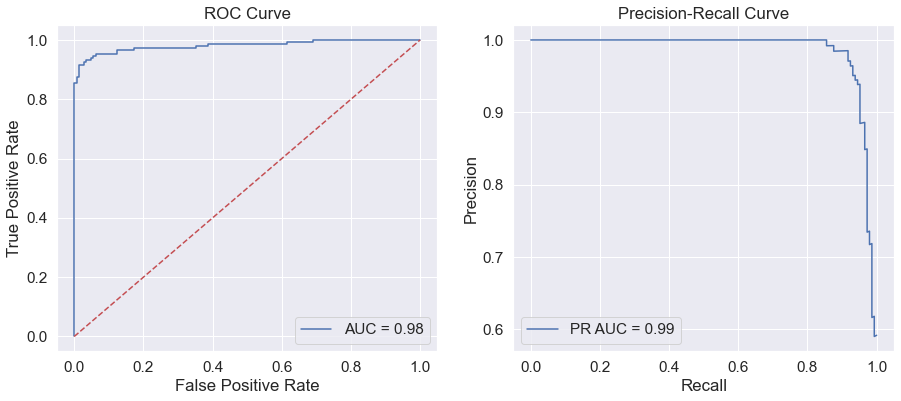

In [148]:
plot_roc_pr_curves(X_nm, y_nm, lr)

Millors resultats amb Smote i NearMiss.

Totes les tècniques donen bons resultats a les dades del train classificant amb notable precissió les dues classes

## METRIC SELECTION CROSS VALIDATION
### SMOTE f1 score

In [149]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)
models = [
    LogisticRegression(solver='liblinear', max_iter=1000),
    RandomForestClassifier(n_estimators=100),
    GaussianNB(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
]

def compare_crossval(X_train, y_train):
    total_iterations = len(models)
    results = []  
    for i, model in enumerate(models, 1):
        print()
        print(f"Model {i}/{total_iterations}: {model.__class__.__name__}") 
        scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1')
        mean_f1 = round(scores.mean(), 3)
        results.append({'Model': model.__class__.__name__, 'Mean F1 Score': mean_f1})  
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(by='Mean F1 Score', ascending=False)
    
    return df_results

compare_crossval(X_smote, y_smote)


Model 1/5: LogisticRegression

Model 2/5: RandomForestClassifier

Model 3/5: GaussianNB

Model 4/5: AdaBoostClassifier

Model 5/5: GradientBoostingClassifier


,Model,Mean F1 Score
1,RandomForestClassifier,1.000
4,GradientBoostingClassifier,0.993
3,AdaBoostClassifier,0.982
0,LogisticRegression,0.957
2,GaussianNB,0.887


### ROS f1 score

In [150]:
compare_crossval(X_ros, y_ros)


Model 1/5: LogisticRegression

Model 2/5: RandomForestClassifier

Model 3/5: GaussianNB

Model 4/5: AdaBoostClassifier

Model 5/5: GradientBoostingClassifier


,Model,Mean F1 Score
1,RandomForestClassifier,1.000
4,GradientBoostingClassifier,0.998
3,AdaBoostClassifier,0.995
0,LogisticRegression,0.943
2,GaussianNB,0.888


## NEAR MISS F1 Score

In [151]:
compare_crossval(X_nm, y_nm)


Model 1/5: LogisticRegression

Model 2/5: RandomForestClassifier

Model 3/5: GaussianNB

Model 4/5: AdaBoostClassifier

Model 5/5: GradientBoostingClassifier


,Model,Mean F1 Score
1,RandomForestClassifier,0.960
4,GradientBoostingClassifier,0.946
3,AdaBoostClassifier,0.943
2,GaussianNB,0.942
0,LogisticRegression,0.901


## RANDOM UNDER SAMPLING F1 Score

In [152]:
compare_crossval(X_rus, y_rus)


Model 1/5: LogisticRegression

Model 2/5: RandomForestClassifier

Model 3/5: GaussianNB

Model 4/5: AdaBoostClassifier

Model 5/5: GradientBoostingClassifier


,Model,Mean F1 Score
0,LogisticRegression,0.929
1,RandomForestClassifier,0.923
4,GradientBoostingClassifier,0.921
3,AdaBoostClassifier,0.906
2,GaussianNB,0.884


## DATASET ORIGINAL

In [168]:
compare_crossval(X_train, y_train)


Model 1/5: LogisticRegression

Model 2/5: RandomForestClassifier

Model 3/5: GaussianNB

Model 4/5: AdaBoostClassifier

Model 5/5: GradientBoostingClassifier


,Model,Mean F1 Score
1,RandomForestClassifier,0.800
3,AdaBoostClassifier,0.685
0,LogisticRegression,0.681
4,GradientBoostingClassifier,0.490
2,GaussianNB,0.143


Veiem bones puntuacions de f1-score a tots els datasets equilibrats amb les tècniqyes d'oversampling i undersampling.

Les tècniques d'oversampling de SMOTE i ROS semblen ser les que més bé funcionen. A continuació mirarem com de bé generalitza el nostre model amb les dades del test

# APLIQUEM ELS MODELS AL TEST

He aplicat tots el models que he fet servir al train per curiositat. Podria haver utilitzat només dos de cada tècnica

Hyperparameter search després de 9 hores seguia executant, l'he tret.

Ens fixem sobretot en wheighted avg f1-score, ja que dona més importància a les classes amb més instàncies vertaderes, que és útil per a situacions de desbalanceig de classes.

SMOTE 

In [153]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    
    print(f"\n{model.__class__.__name__} - Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_test))
    
    print(f"\n{model.__class__.__name__} - Classification Report:")
    print(classification_report(y_test, y_pred_test))

evaluate_model(AdaBoostClassifier(), X_smote, y_smote, X_test, y_test)
evaluate_model(GradientBoostingClassifier(), X_smote, y_smote, X_test, y_test)
evaluate_model(LogisticRegression(), X_smote, y_smote, X_test, y_test)
evaluate_model(RandomForestClassifier(), X_smote, y_smote, X_test, y_test)


AdaBoostClassifier - Confusion Matrix:
[[38626   663]
 [    5    31]]

AdaBoostClassifier - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     39289
           1       0.04      0.86      0.08        36

    accuracy                           0.98     39325
   macro avg       0.52      0.92      0.54     39325
weighted avg       1.00      0.98      0.99     39325


GradientBoostingClassifier - Confusion Matrix:
[[38879   410]
 [    4    32]]

GradientBoostingClassifier - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     39289
           1       0.07      0.89      0.13        36

    accuracy                           0.99     39325
   macro avg       0.54      0.94      0.56     39325
weighted avg       1.00      0.99      0.99     39325



c:\Users\manel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogisticRegression - Confusion Matrix:
[[37911  1378]
 [    4    32]]

LogisticRegression - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     39289
           1       0.02      0.89      0.04        36

    accuracy                           0.96     39325
   macro avg       0.51      0.93      0.51     39325
weighted avg       1.00      0.96      0.98     39325


RandomForestClassifier - Confusion Matrix:
[[39289     0]
 [    9    27]]

RandomForestClassifier - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39289
           1       1.00      0.75      0.86        36

    accuracy                           1.00     39325
   macro avg       1.00      0.88      0.93     39325
weighted avg       1.00      1.00      1.00     39325



Els millors resultats, tal com hem vist al fer el cross validation, s'obtenen amb el model random forest.

La matriu de confussio mostra que classifica totes les instàncies de classe 0 bé i 29/36 de la classe 1 bé amb f1 scores alts per les dues classes.

## RANDOM OVER SAMPLING

In [154]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    
    print(f"\n{model.__class__.__name__} - Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_test))
    
    print(f"\n{model.__class__.__name__} - Classification Report:")
    print(classification_report(y_test, y_pred_test))

evaluate_model(AdaBoostClassifier(), X_ros, y_ros,X_test, y_test)
evaluate_model(GradientBoostingClassifier(), X_ros, y_ros, X_test, y_test)
evaluate_model(LogisticRegression(), X_ros, y_ros, X_test, y_test)
evaluate_model(RandomForestClassifier(), X_ros, y_ros, X_test, y_test)


AdaBoostClassifier - Confusion Matrix:
[[38881   408]
 [    5    31]]

AdaBoostClassifier - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     39289
           1       0.07      0.86      0.13        36

    accuracy                           0.99     39325
   macro avg       0.54      0.93      0.56     39325
weighted avg       1.00      0.99      0.99     39325


GradientBoostingClassifier - Confusion Matrix:
[[39145   144]
 [    4    32]]

GradientBoostingClassifier - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39289
           1       0.18      0.89      0.30        36

    accuracy                           1.00     39325
   macro avg       0.59      0.94      0.65     39325
weighted avg       1.00      1.00      1.00     39325



c:\Users\manel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogisticRegression - Confusion Matrix:
[[37878  1411]
 [    5    31]]

LogisticRegression - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     39289
           1       0.02      0.86      0.04        36

    accuracy                           0.96     39325
   macro avg       0.51      0.91      0.51     39325
weighted avg       1.00      0.96      0.98     39325


RandomForestClassifier - Confusion Matrix:
[[39289     0]
 [   11    25]]

RandomForestClassifier - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39289
           1       1.00      0.69      0.82        36

    accuracy                           1.00     39325
   macro avg       1.00      0.85      0.91     39325
weighted avg       1.00      1.00      1.00     39325



Random forest bons resultats tot i que té una recall de 0.69 a la classe 1.

Funciona lleugerament pitjor que el model avaluat amb les dades SMOTE

Les matrius de confussió indiquen que és un model una mica inferior a l'entrenat amb les dades SMOTE tot i que és capaç de detecatr fraus amb precisió.

## NEAR MISS

In [155]:
evaluate_model(AdaBoostClassifier(), X_nm, y_nm, X_test, y_test)
evaluate_model(GradientBoostingClassifier(), X_nm, y_nm, X_test, y_test)
evaluate_model(LogisticRegression(), X_nm, y_nm, X_test, y_test)
evaluate_model(RandomForestClassifier(), X_nm, y_nm, X_test, y_test)


AdaBoostClassifier - Confusion Matrix:
[[ 2377 36912]
 [    0    36]]

AdaBoostClassifier - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.11     39289
           1       0.00      1.00      0.00        36

    accuracy                           0.06     39325
   macro avg       0.50      0.53      0.06     39325
weighted avg       1.00      0.06      0.11     39325


GradientBoostingClassifier - Confusion Matrix:
[[ 3414 35875]
 [    1    35]]

GradientBoostingClassifier - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.09      0.16     39289
           1       0.00      0.97      0.00        36

    accuracy                           0.09     39325
   macro avg       0.50      0.53      0.08     39325
weighted avg       1.00      0.09      0.16     39325


LogisticRegression - Confusion Matrix:
[[20924 18365]
 [    4    32]]

LogisticRegression - Class

Aquesta tècnica d'equilibri de dades no ha estat molt efectiva per classificar les transaccions amb resultats molt pobres. No és capaç de generealitzar

## Random Under Sampling

In [156]:
evaluate_model(AdaBoostClassifier(), X_rus, y_rus, X_test, y_test)
evaluate_model(GradientBoostingClassifier(), X_rus, y_rus, X_test, y_test)
evaluate_model(LogisticRegression(), X_rus, y_rus, X_test, y_test)
evaluate_model(RandomForestClassifier(), X_rus, y_rus, X_test, y_test)


AdaBoostClassifier - Confusion Matrix:
[[36356  2933]
 [    2    34]]

AdaBoostClassifier - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     39289
           1       0.01      0.94      0.02        36

    accuracy                           0.93     39325
   macro avg       0.51      0.93      0.49     39325
weighted avg       1.00      0.93      0.96     39325


GradientBoostingClassifier - Confusion Matrix:
[[37119  2170]
 [    3    33]]

GradientBoostingClassifier - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     39289
           1       0.01      0.92      0.03        36

    accuracy                           0.94     39325
   macro avg       0.51      0.93      0.50     39325
weighted avg       1.00      0.94      0.97     39325


LogisticRegression - Confusion Matrix:
[[36500  2789]
 [    2    34]]

LogisticRegression - Class

Funciona molt millor que la tècnica del Near Miss tot i que es queda molt enrere de les tècniques d'oversampling.

## ANÀLISIS FINAL

## SMOTE
FEATURE IMPORTANCE: En aquest datset no té molt sentit fer un feature importance ja que no sabem que representa la majoria de les nostres dades degut a un pca previ per preservar la seguretat de les dades,

AUC ROC: 0.97
AUC PR: 0.87
Optimal Threshold (F1): 0.45


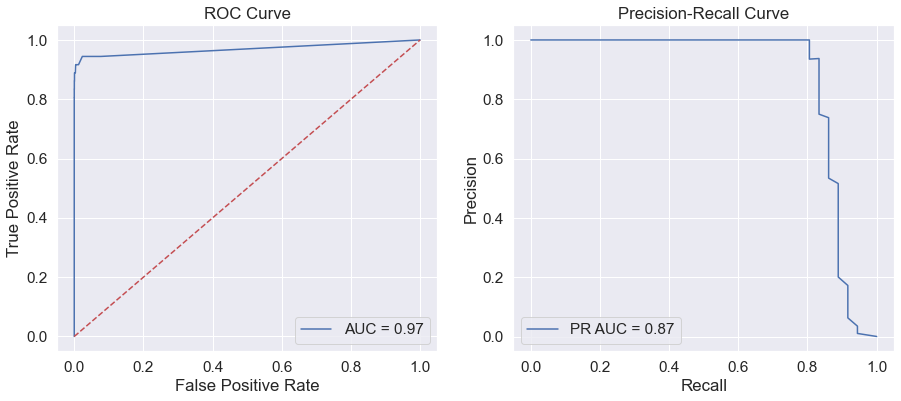

In [157]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_smote, y_smote) 
plot_roc_pr_curves(X_test, y_test, random_forest_model)

Tenim molt bons resultats a l'hora de fer les dues corbes amb auc de la corba PR molt alt, 0.87.

Aquest fet indica que el model és capaç de generelitzar i de detectar transaccions fraudulentes amb precisió.

El trheshold és més elevat que el train test, fet lògic ja que el model del train tenia "més bons" resultats.

In [158]:
def plot_analysis_results(X, y, y_prob, y_pred):
    fig, ax = plt.subplots(figsize=(9, 6))
    scatter = ax.scatter(y_prob[:, 1], y_pred, c=y, cmap='coolwarm')  # Cambiar el cmap a 'coolwarm'
    ax.set_xlabel('Probability of Class 1')
    ax.set_ylabel('Predicted Class')
    ax.set_title('Prediction vs. Probability of Class 1')
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('True Label')
    plt.tight_layout()
    plt.show()
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf, annot=True, cmap='coolwarm', fmt='g')  # Cambiar el cmap a 'coolwarm'
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


Podem mirar més enllà els erros del models amb les gràfiques de prediccions vs probabilitat de classe 1 i generant les matrius de confusió

C:\Users\manel\AppData\Local\Temp\ipykernel_15572\1887130546.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scatter, ax=ax)


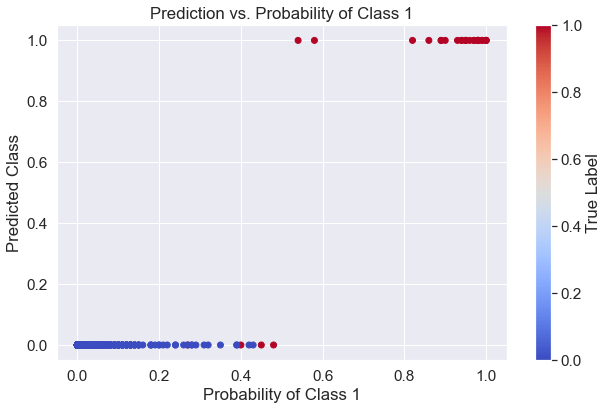

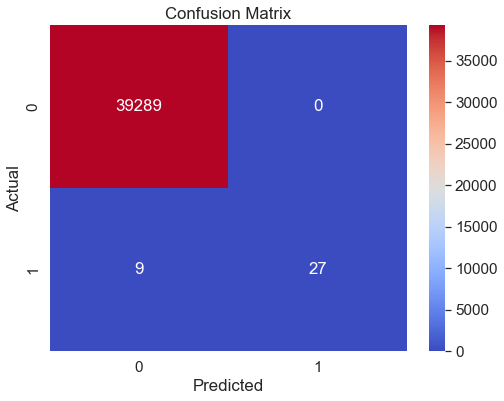

In [159]:
y_prob_smote = random_forest_model.predict_proba(X_test)
y_pred_smote = random_forest_model.predict(X_test)
plot_analysis_results(X_test, y_test, y_prob_smote, y_pred_smote)

Podem veure que la classe 0 és classificada a la perfecció, però comet alguns errors a l'hora de detectar fraus. Tot i així és model molt precís.

## ROS

AUC ROC: 0.96
AUC PR: 0.86
Optimal Threshold (F1): 0.22


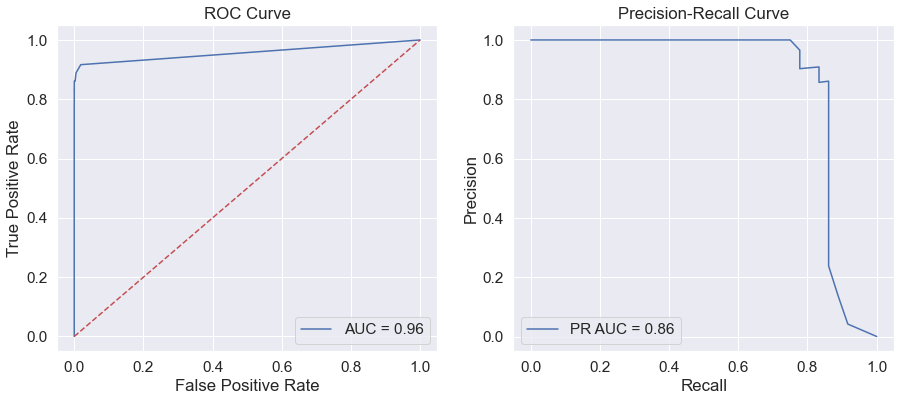

In [160]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_ros, y_ros) 
plot_roc_pr_curves(X_test, y_test, random_forest_model)

C:\Users\manel\AppData\Local\Temp\ipykernel_15572\1887130546.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scatter, ax=ax)


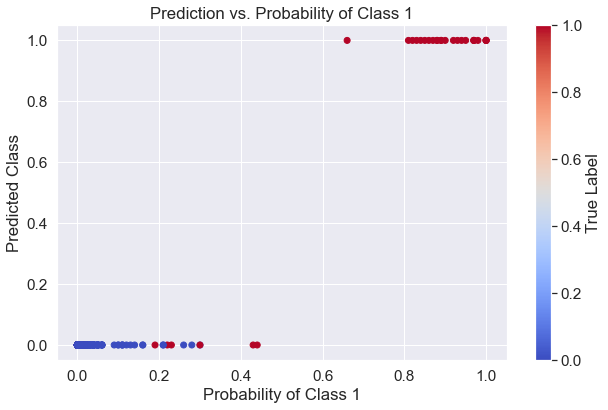

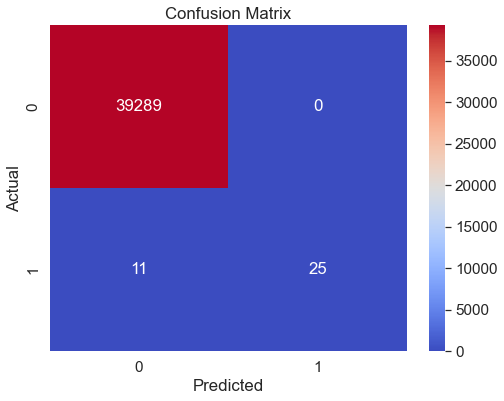

In [161]:
y_prob_ros = random_forest_model.predict_proba(X_test)
y_pred_ros = random_forest_model.predict(X_test)
plot_analysis_results(X_test, y_test, y_prob_ros, y_pred_ros)

Podriem dir el mateix que al SMOTE, el ROS, demostra una gran capacitat per poder classificar amb precisió les dues classes tot i que comet més errors que l'SMOTE.

Aquestes dues tècniques donen resultats molt positius.

Les tècniques d'oversampling funcionen en aquest dataset més bé que les d'undersampling

## NEAR MISS

AUC ROC: 0.90
AUC PR: 0.72
Optimal Threshold (F1): 0.98


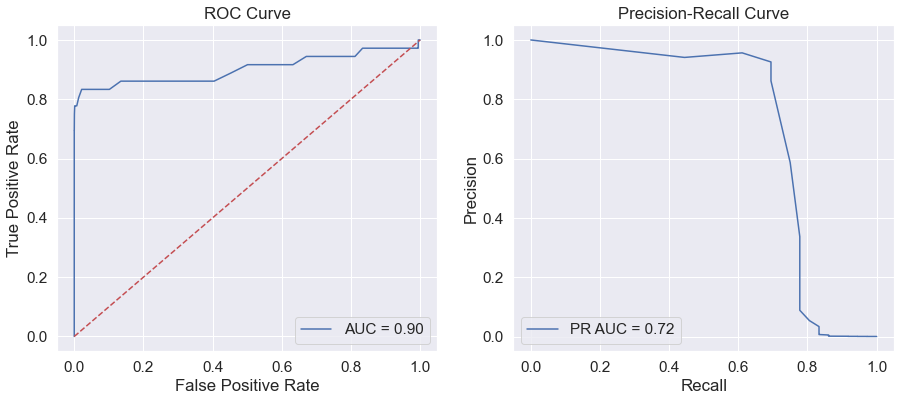

In [162]:
random_forest_model =RandomForestClassifier()
random_forest_model.fit(X_nm, y_nm) 
plot_roc_pr_curves(X_test, y_test, random_forest_model)

C:\Users\manel\AppData\Local\Temp\ipykernel_15572\1887130546.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scatter, ax=ax)


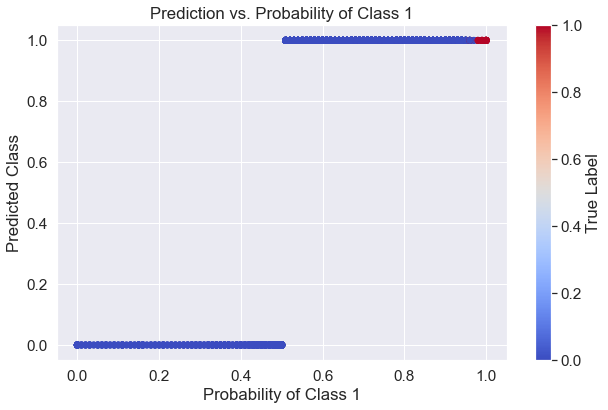

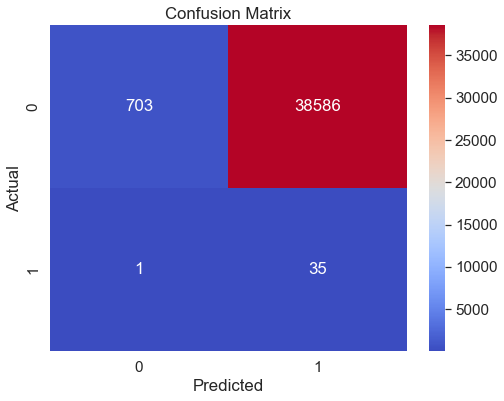

In [163]:
y_prob_nm = random_forest_model.predict_proba(X_test)
y_pred_nm = random_forest_model.predict(X_test)
plot_analysis_results(X_test, y_test, y_prob_nm, y_pred_nm)

Resultats molt dolents, no sent capaç de distingir entre les dues classes. Prediu tot com classe 1

## RANDOM UNDER SAMPLING

AUC ROC: 0.96
AUC PR: 0.74
Optimal Threshold (F1): 0.97


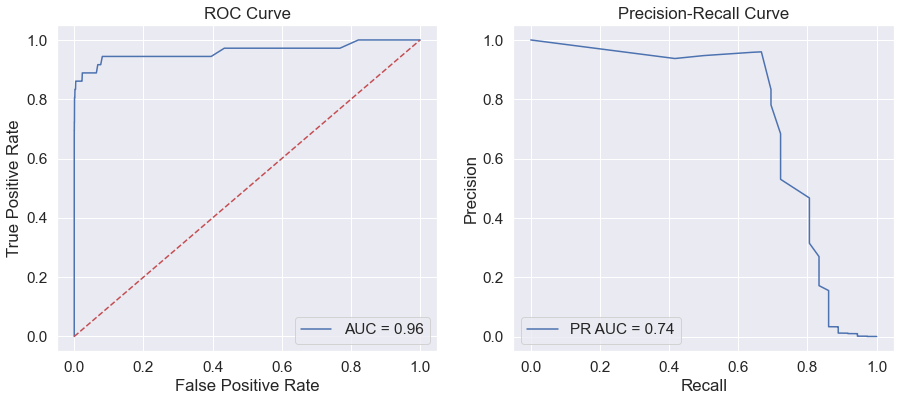

In [164]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_rus, y_rus) 
plot_roc_pr_curves(X_test, y_test, random_forest_model)

C:\Users\manel\AppData\Local\Temp\ipykernel_15572\1887130546.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scatter, ax=ax)


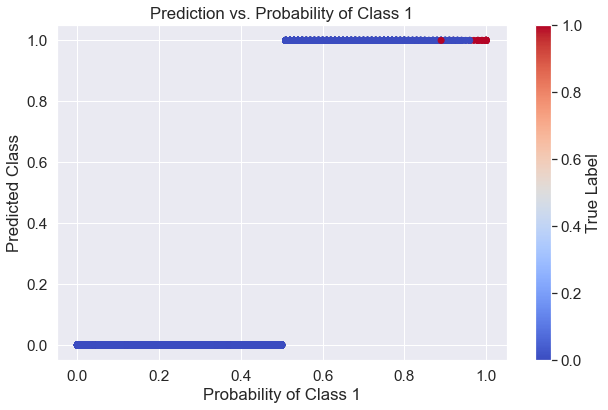

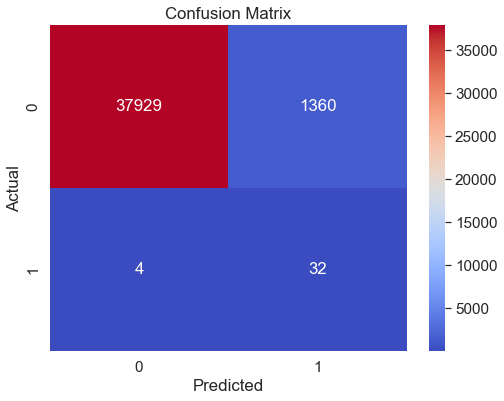

In [165]:
y_prob_rus = random_forest_model.predict_proba(X_test)
y_pred_rus = random_forest_model.predict(X_test)
plot_analysis_results(X_test, y_test, y_prob_rus, y_pred_rus)

Resultats millots que l'anterior tècnica tot i que molt inferior a les tècniques d'oversampling